In [ ]:
import state_dicts
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import evaluation_functions as ef

In [2]:
path_phi = 'simulation_data/ad_angle_PHI.xvg'
path_psi = 'simulation_data/ad_angle_PSI.xvg'
# read in the files for psi and phi
psi_raw = pd.read_csv(path_psi, header=None, skiprows=range(17), sep='\s+')
phi_raw = pd.read_csv(path_phi, header=None, skiprows=range(17), sep='\s+')
# change representation of angles to radians and get values of df
psi = psi_raw.values
psi[:, 1] *= 2*np.pi/360
phi = phi_raw.values
phi[:, 1] *= 2*np.pi/360


\begin{align*}
    \text{Final Project}
\end{align*}

\begin{align*}
    \text{Hannes Caesar}
\end{align*}

# Introduction

When simulating biological processes such as protein folding, a common problem is that physically relevant time scales are computationally hard to achieve. Additionally, even for relatively small structures, the obtained data in form of spatial trajectories can be overwhelmingly difficult to analyse.  
One approach, towards a more statistical description are Markov State Models (MSM). When constructed right, Markov State Models give the ability to predict long term behaviour in a simplified description, which is humanly understandable.
For this, some available input data, e.g. from a MD simulation, is taken and coarse grained to obtain a number of different states. These states are conformations of the investigated system, which appear to have significance. The definition of these states is the first challenge, when constructing a MSM.  
In the second step this state model is parameterised with the rates with which the system changes between these states. A transition matrix is defined, containing the transition probabilities between the states. This matrix can than be used to predict the system's dynamics by propagating a probability vector, which describes the probabilities to find the system in a particular state at the start of the simulation.  
  
In this project, a simple MSM is created based on a MD simulation of alanine dipeptide (*Ac-Ala-NHCH3*), further abbreviated by "AD". The state definition is done via local metastable energy minima, which can be found by looking at the backbone dihedral angles $\Phi$ and $\Psi$ of AD. Based on these states, the transition matrix is constructed.  
To validate, whether the system is described accurately, the model must be *Markovian*, meaning that is doesn't show any sign of a "memory". This means, that the evolution of the system after some time onwards, only depends on the state the system is in at that time and not on the states the system visited before. Two ways of checking this condition will be presented. 

# MD simulation and data generation

In the following, the simulation of alanine dipeptide (Ac-Ala-NHCH3), using the free software package *GROMACS* is described. The simulation was carried out at a temperature of $300 K$ in a water filled, cubic simulation box. The simulation was run for total time of $t_{sim} = 5ns$, using a time step of $dt=0.002 ps$ and the Amber ff99SB*-ILDN force field. Writing out the coordinates to the .xtc file every 100 steps, the resulting trajectory for the analysis has a temporal resolution of 5 frames/ns. 

Consequently, the total amount of steps was $n_{steps} = \frac{t_{sim}}{dt} = 2.5\cdot10^{6}$.

Together with the Task sheet the files 
* `ad.pdb` : protein data bank coordinate file of AD
* `MD.mdp` : molecular dynamics parameter file, containing the necesseary parameters for the MD simulation
* `SD.mdp` : molecular dynamics parameter file, containting the necesseary parameters for the steepest descent minimization  

were provided.  
The file preparations and up until the final MD simulation is described in the following 7 steps. (Reocurring flags are not described several times):

1. First, the .pdb file is read and hydrogen atoms are added to the molecules. A structure file of the .gro format and a topology file are created, for which a force field and a water model need to be selected.  

   **gmx pdb2gmx -f ad.pdb -o ad.gro -p ad.top**
    * -f : specifies the input file
    * -o : specifies the output file
    * -p : specifies the topology file  
    
   After excecuting the above command, you get prompted to select a force field. The force field Amber ff99SB*-ILDN (AMBER99SB-ILDN) (#6) is chosen. Then the static water model TIP3P (#1) is chosen. 
    
2. In the second step, the peptide is centered in a cubic simulation box and aligned with its principal axes along the coordinate axes.  

    **gmx editconf -bt cubic -f ad.gro -c -princ -d 0.6 -o ad_box.gro**
    
    * -bt : define box geometry
    * -c : puts geometric center of molecule at (0,0,0) (redundant, because "-d" implies "-c")
    * -princ : aligns principal axes of molecule along the coordinate axes.
    * -d : adjusts system dimension such that the shortest distance between the molecule and the box is -d  
   
   In the output structure file `ad_box.gro`, the box dimension was found to be $1.91896\text{nm}$, which is more than two times the cutoff radius $r_{vdw}=0.9{nm}$. 
3. Afterwards the box is filled with water and the topology file `ad.top` is updated. 

    **gmx solvate -cp ad_box.gro -cs -o ad_box_water.gro -p ad.top**
    * -cp : input coordinate file, used as the **solvate**. 
    * -cs : input **solvent** file. default is SPC (Simple PointCharge water)

4. To prepare a .tpr file, whis is later going to be used for a simulation, the `grompp` comand is used. It reads in a topology file together with the coordinate file and the relevant MD parameter. First, the previously generated coordinate file `ad_box_water.gro` is read to prepare a run input file for a steepest descent minimization of the atom positions.

    **gmx grompp -f SD.mdp -c ad_box_water.gro -p ad.top -o ad_water_SDmin.tpr**
    * -c : coordinate file
 
5. To minimize the energy a short simulation is run. All relevant information are contained in the previuously generated file `ad_water_SDmin.tpr`, which can be used as the input file for the `mdrun` command. 

   **gmx mdrun -v -deffnm ad_water_SDmin**
   
   * -v : verbose(show more information) or in gromacs' words: "Be loud and noisy."
   * -deffnm : sets file name (without extension) for all file options (inputs/outputs)
   
6. In analogy to steps (4) and (5), in steps (6) and (7), a .tpr file is generated with `grompp`, which is then used as an input file for the MD simulation. The main difference is, that the coordinate file for the `grompp` command contains the coordinates after SD minimization and the parameters for the simulations are the ones from `MD.mdp`. 

    **gmx grompp -f MD.mdp -c ad_box_water_SDmin.gro -p ad.top -o ad_water_MD.tpr** 
    
    
    
7. **gmx mdrun -v -deffnm ad_water_MD**

## Calculation of dihedral angles 

Below is an image of the investigated alanine dipetide, taken from the molecular visualisation program *VMD*. The relevant atoms as well as the two dihedral angles are labelled.

In [ ]:
from PIL import Image
Image.open('Dihedral_VMD_AD.png')

A dihedral angle is the angle between to intersecting planes. To calculate such an angle in a molecule, two sets of each 3 atoms need to be specified, where two atoms of both sets are identical and the other ones are different. With these two sets two planes are constructed and an angle between them is then defined via their surface normals. Since two atoms of the sets are the same, a change of the dihedral angle can be seen as a rotation around the intersecting line of the two planes. This rotational axis is therefore defined by the line that connects the two common atoms of the two sets.  

In proteins, $\Phi$ and $\Psi$ form a pairs of dihedral angles along the backbone chain. Here the rotational axis of $\Phi$ is defined as the connecting line between a $C_\alpha$ atom and its neighbouring nitrogen ($N$)atom. The rotational axis of $\Psi$ is the connecting line between $C_\alpha$ (CA in the above image) and the neighbouring carbon ($C$) atom of the backbone chain. The AD molecule has only one pair ($\Psi$,$\Phi$) of dihedrals, shown in the image above.

To calculate dihedral angles using the gromacs command **gmx angle**, the index file need to contain groups with 4 indices. These 4 atom indices specifiy the two planes, as described above. The first 3 entries are the set of atoms for the first plane and the last 3 entries are the set of atoms for the second plane. So in order to calculate both $\Phi$ and $\Psi$, and index file with two groups needs to be created.  
The atom indices of the labelled atoms are (left to right) as shown above are:$[5, 7, 9, 15, 17]$  
Therefore the two groups in the index `dihedral_ndx` are defined as follows:  
[ Phi ]  
5 7 9 15  

[ Psi ]  
7 9 15 17  

With this, the following command was used to generate two .xvg files containing the evolution of the respective angle.  
**gmx angle -f ad_water_MD.xtc -n dihedral_idx.ndx -type dihedral -ov ad_angle_PHI/PSI.xvg**
* -f : xtc file contains the coordinates of the system at each point of the MD trajectory
* -n : index file with the two index groups
* -type : type of angle which shall be calculated
* -ov : output file 


## Ramachandran plot

Due to the geometry of petides and larger protein structures not all possible combinations of $\Phi$ and $\Psi$ are energetically favourable. A Ramachandran plot is a way of visualizing low energy states by plotting occupation of the whole (periodic) $\Phi$-$\Psi$-space. Energetically low regions will be higher populated when compared to energetically higher regions. 

Below, the two xvg files are read into a pandas dataframe and the values are extracted into a numpy array. Gromacs gives angles in degrees. The angle values (in the second column) are converted to radians. 

In [ ]:
path_phi = 'simulation_data_long/ad_angle_PHI_long.xvg'
path_psi = 'simulation_data_long/ad_angle_PSI_long.xvg'
# read in the files for psi and phi
psi_raw = pd.read_csv(path_psi, header=None, skiprows=range(17), sep='\s+')
phi_raw = pd.read_csv(path_phi, header=None, skiprows=range(17), sep='\s+')
# change representation of angles to radians and get values of df
psi = psi_raw.values
psi[:, 1] *= 2*np.pi/360
phi = phi_raw.values
phi[:, 1] *= 2*np.pi/360


The function `ramachandran_plot` plots a 2D histogram based on the trajectories of angles $\Phi(t)$ and $\Psi(t)$. In addition, a vertical and horizontal line are plotted and the occupation probabilities along these lines are shown. With the parameter **xy_idx** the constant x and y values of the vertical and horizontal line can be defined in relative coordinates.

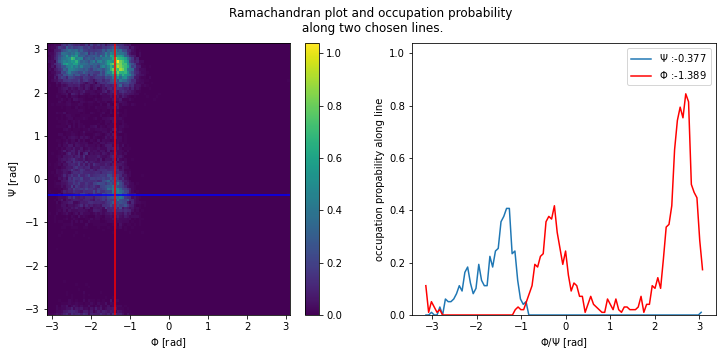

In [5]:
plot = ef.ramachandran_plot(phi, psi, xy_idx=[0.29, 0.44])

The Ramachandran plot clearly shows three minima, where two of them are next to each other and the third one is a bit seperated. The centers of the first and the second minima lie at values of about $(\Phi_1,\Psi_1) = (-2.45, 2.63)$ and $(\Phi_2,\Psi_2) = (-1.26, 2.63)$, with the unit being radiant.  
The third minima does not show a clear center but shows the highest occupation probability at a value of around $(\Phi_3,\Psi_3) = (-1.39, -0.38)$.  
  
While The first two minima show a clear center of highest occupation probability, it is hard to make out a clear barrier between them. Between the upper minima (1,2) and the one in the middel (3), in a range where $0.5\text{rad} < \Psi < 2\text{rad}$, the occupation probability is much smaller than at the centers but never really becomes zero. Therefore it is also not completely clear where the boundary between these states lies. 
  
The states 1 and 2 extend over the "boundaries" of the plot and continue at the bottom. In the range of $-2.8\text{rad} < \Psi < -1.3\text{rad}$ there are almost no points that have been visited during the simulation. Consequently, there is a clear line, where minima 3 ends and 1/2 begin. The same apllies for ther area on the right of the minima. 

# Markov State Model 

In the following the Markov State Model is build. 
One of the main strengths of a MSM is, that is able to simplify the representation of the system's evolution over time, while still providing meaningful statistical data.  
Constructing a MSM is a two step process. First the system's configurations are assigned to a set of states. 
In the second step, the time evolution of the system's state is used to calculate transition probabilities. These are probabilities with which the system changes between the specific states within a certain time interval. 

## State definitions

In order to generate a MSM, the time evolutions of $\phi$ and $\psi$ need to be combined to obtain a trajectory of states, $s(t)$. Therefore the $\phi$/$\psi$-plane, as shown above, is divided into state regions of the form of rectangles. These rectangles are then assigned to different states. That way, each point $(\Phi , \Psi)$ in the plane lies in only one rectangle and can therefore clearly be assigned to one of the defined states of the system. The state trajectory $s(t)\in\{1,2,3\}$ is then defined so that for each point in time it contains the state, the system was in at that time.
$s(t)$ could look something like this:
\begin{align*}
    s(t) = 
    \left[
        \begin{array}{cc}
            t_1 & 1\\
            t_2 & 3\\
            t_3 & 3\\
            \cdot & \cdot\\
            \cdot & \cdot\\
            \cdot & \cdot\\
            t_N & 2
        \end{array}
    \right]
\end{align*}  
  
Looking at the occupation probabilities in the ramachandran plot, three different states are defined. Since the observables are periodic within $2\pi$, the rectangles need to be defined periodically as well.

The code below shows, how the states are defined. All rectangles are described with a list of two lists, containing the indices of the 4 corners of the rectangles, $[[\Phi_{min}, \Phi_{max}],[\Psi_{min}, \Psi_{max}]]$. All rectangles belonging to the same state are put into another list and then stored in a dictionary, called **rect_dict_1**. 

In [6]:
# define rectangle(s) for state 1. put all lists in another list, called rec_list
s1_rec_ul = [[-np.pi, -1.95], [1.3, np.pi]]
s1_rec_ur = [[1.3, np.pi], [1.3, np.pi]]
s1_rec_ll = [[-np.pi, -1.95], [-np.pi, -2]]
s1_rec_lr = [[1.3, np.pi], [-np.pi, -2]]
rec_list_s1 = [s1_rec_ul, s1_rec_ur, s1_rec_ll, s1_rec_lr]

# define rectangle(s) for state 2. put all lists in another list, called rec_list
s2_rec_u = [[-1.95, 1.3], [1.3, np.pi]]
s2_rec_l = [[-1.95, 1.3], [-np.pi, -2]]
rec_list_s2 = [s2_rec_u, s2_rec_l]

# define rectangle(s) for state 3. put all lists in another list, called rec_list
s3_rec = [[-np.pi, np.pi], [-2, 1.3]]
rec_list_s3 = [s3_rec]

# make dictionary where rect_dict['statei'] gives a list of the corresponding rectangles
rect_dict_1 = {
    'state1': rec_list_s1,
    'state2': rec_list_s2,
    'state3': rec_list_s3,
}

Below is a visualization of the defined states via rectangles. The function `visualize_states` from *evaluation_functions.py* is used. Rectangles of the same color belong to the same state and the state assignment is done above the boundaries of the shown $\Phi/\Psi$-plane.

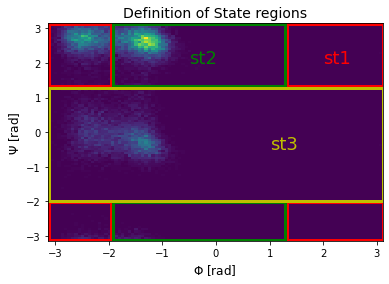

In [7]:
ef.visualize_states(rect_dict_1, phi, psi, color_list=['r', 'g', 'y'])

The function `make_state_traj` is now used to generate a state trajectory **s_1** according to the state definition above. It takes as inputs the time evolutions of the two angles and a state dictionary of the format described above. It then returns the time evolution of the system's state. 

In [9]:
s_1 = ef.make_state_traj(phi, psi, rect_dict_1, core_def=False)

## Transition matrices
To fit the data to a model, that describes transitions between the defined states, a transition matrix is defined.
  
Given a probability vector 
\begin{align*}
\vec{p}(t) = 
    \left[
        \begin{array}{c}
            p_1(t)\\
            p_2(t)\\
            p_3(t)\\
        \end{array}
    \right]
\end{align*}
with $\sum_ip_i = 1$, where $p_i(t)$ is the probability to be in state i at the time t, a transition matrix $T(\tau)$ can be used to calculate the probability vector  $\vec{p}(t+\tau)$ after some time $\tau$ by multiplying $T(\tau)$ from the right. A transition matrix is therefore characterised by its lag time $\tau$. When constructing $T(\tau)$ from a state trajectory $s(t)$, all pairs $(s_1(t_1), s_2(t_2)) \in s(t)$  along the trajectory with a time difference $t_2-t_1=\tau$ are evaluated and the state transition $s_1 \rightarrow s_2$ is counted.  
In experiments and simulations, $s(t)$ will always be discretised in time. Considering a state trajectory with a time difference, $dt$, between recorded frames, the number of such transitions from some state $i$ to $j$ during the observation time $t_{total}$ can be formally written as

\begin{align*}
    N_{ij}(\tau) &= \sum_{t=t_0}^{t_{total}-\tau}\delta_{s(t),i}\delta_{s(t+\tau),j}\\
                 &= \sum_{n_t=0}^{N-n_{tau}}\delta_{s(n_t\cdot dt),i}\delta_{s((n_t+n_{tau})\cdot dt),j}\\
                 &= \sum_{n_t=0}^{N-n_{tau}}\delta_{s(n_t),i}\delta_{s(n_t+n_{tau}),j}
\end{align*}

where we used $N=\frac{t_{total}}{dt}$ and $n_{tau} = \frac{\tau}{dt}$. Since the sampling rate is assumed to be constant $dt$ was omitted in the last step. Here, $\delta_{s(n_t), i}$ is the Kronecker-Delta which is $1$ if the system was in state $i$ at the time $t=n_t dt$ and otherwise is $0$.

By normalizing the rows we get the probabilities
\begin{equation}\label{eq:p_ij}
    P_{ij} = P_{i\rightarrow j} = \frac{N_{ij}(\tau)}{\sum_{j=1}^{3}N_{ij}(\tau)}
\end{equation}
to observe a transition,$i \rightarrow j$, from state $i$ to state $j$. 
With this the transition matrix 

\begin{align}
    T(\tau) =
    \left( 
        \begin{array}{ccc}
               P_{11}(\tau)  & P_{12}(\tau) & P_{13}(\tau) \\
               P_{21}(\tau)  & P_{22}(\tau) & P_{23}(\tau)\\
               P_{31}(\tau)  & P_{32}(\tau) & P_{33}(\tau)\\
        \end{array}
    \right)
\end{align}

can be defined and used to propagate $p$.

\begin{align*}
    p(t+\tau) & = &  (p_1(t), p_2(t), p_3(t))
    \left( 
        \begin{array}{ccc}
               P_{11}(\tau)  & P_{12}(\tau) & P_{13}(\tau) \\
               P_{21}(\tau)  & P_{22}(\tau) & P_{23}(\tau)\\
               P_{31}(\tau)  & P_{32}(\tau) & P_{33}(\tau)\\
        \end{array}
    \right)\\ \\
           & = & \left(
                \begin{array}{c}
                    p_1(t)P_{11}(\tau) + p_2(t)P_{21}(\tau) + p_3(t)P_{31} \\
                    p_1(t)P_{12}(\tau) + p_2(t)P_{22}(\tau) + p_3(t)P_{32} \\
                    p_1(t)P_{13}(\tau) + p_2(t)P_{23}(\tau) + p_3(t)P_{33} \\
                 \end{array}
              \right)^T
\end{align*}

The propagated vector $p(t+\tau)$ is again a probability vector. Looking at the first entry, ones sees, that the probablity to be in state $1$ after some time $t+\tau$ is the sum of the probabilities to go into that state $P_{i1}$ from any of the other states multiplied with the probabilities with which the the system was in that state at time $t$. Same holds for the other entries and gives a good intuition on what the transition matrix $T(\tau)$ is doing, when applied on a probability vector.  

###### A few things to note about transition matrices $T$:
1. By definition the rows of $T$ sum up to $1$: $\sum^3_{j=1}T_{ij} = 1$  
    and are therfore probability vector. 
2. $T$ has the an eigenvalue of $\lambda_1=1$: Because of 1.), $T^T$ has the eigenvector $(1,1,1)^T$ with an eigenvalue of $1$. Since $T^T-\lambda I_3$ has the same determinant as $T-\lambda I_3$, the matrix $T$ also has an eigenvalue of $\lambda_1=1$
3. It can easily be shown, that if $T$ is transition matrix, that $T^m$ for any $m \in \mathbb{N}$ is also a transition matrix. 
4. $\lambda_1$ is the largest eigenvalue. This follows from the fact that $T^m$ is also a probabiliy matrix and is not further discussed here. 
5. If $T$ has 3 pairwise different eigenvalues $\{\lambda_1, \lambda_2, \lambda_3\}$, than their exists a ortonormal basis $B=\{v^{(1)},v^{(2)},v^{(3)}\}$ of eigenvectors. This means, that $T$ can be diagonalised, more specifically it exists a matrix $P$, which is invertible with $P^{-1}TP = D_T =diag(\lambda_1, \lambda_2, \lambda_3)$. In this case $P$ is the matrix to change between basis $B$ and the standard basis $S$.

The propagation of a probability vector $p$ as described above can also be described within the basis $B$, leading to a much more simplified expression.  
If $p_S = (p_1, p_2, p_3)$ is the representation of $p$ in the basis $S$ the corresponding representation in $B$ is given by $p_B = (u_1, u_2, u_3)$, where $p_S = u_1v^{(1)} + u_2v^{(2)} + u_3v^{(3)}$. Applying $D_T$ yields: 
\begin{align}\label{eq:lambda_matrix}
    p_B(t+\tau) = (u_1, u_2, u_3)\cdot 
    \left( 
        \begin{array}{ccc}
               \lambda_1(\tau) & 0 & 0 \\
               0 & \lambda_2(\tau) & 0 \\
               0 & 0 & \lambda_3(\tau) \\
        \end{array}
    \right)
    = (\lambda_1(\tau)u_1, \lambda_1(\tau)u_2, \lambda_1(\tau)u_3)
\end{align}

Consequently, in this representaion, applying $T(\tau)$ $m$ times corresponds to multiplying by the eigenvalues $\lambda_i$ of $T(\tau)$ $m$ times.

  
The function `T_of_tau` can be used to calculate a transition matrix from a state trajectory **s** with a lag time **n_tau**, where **n_tau** is an integer multiple of $dt$, the step time between recorded frames. 

## Implied time scales 

In biological systems, there are many conformational changes happening all the time. In order to have a good description, the lag time $\tau$ needs to be chosen correctly. If it is too short it might mistake fluctuations of the structure for acutal state transitions. On the other hand, transitions to other states should take longer than $\tau$ so they can be correctly detected. 
  
The eigenvalue spectrum of $T(\tau)$ gives means to evaluate whether the model is behaving markovian or not. The time scales on which the system changes between states, which are implied by the model, should be independent of the model paramteter $\tau$. Hence, if the model is in fact markovian, the time scales
\begin{equation}\label{eq:timpl}
    t_{impl, i}(\tau) = \frac{\tau}{ln(\lambda_i(\tau))}
\end{equation}
should become constant. Since the biggest eigenvalue is $\lambda_1 = 1$, meaning that the system would not be changing at all after applying the transition matrix, we look at the slowest time scale by checking the above equation for the second largest eigenvalue $\lambda_2$.  

The function `plot_timp` takes two ranges, **tau_range_1/2**, of lag times (in form of integer multiples of $dt$) and a state trajectory **s** as an input. For each of these ranges it calls the function `calc_timp` to calculate the implied time scales for every lag time in that range. `calc_timp` itselfs calls the function `get_lambda2` to calculate the second largest eigenvalue $\lambda_2(\tau)$ of the corresponding matrix $T(\tau)$. With equation \ref{eq:timpl}, the implied time scales are then computed. 

C:\Users\Hannes\Documents\Studium\Master\SS_20\Biomolecular_Simulations\Final_Project_BioSim\evaluation_functions.py:173: ComplexWarning: Casting complex values to real discards the imaginary part
  timp[i] = - tau/np.log(lambda2)


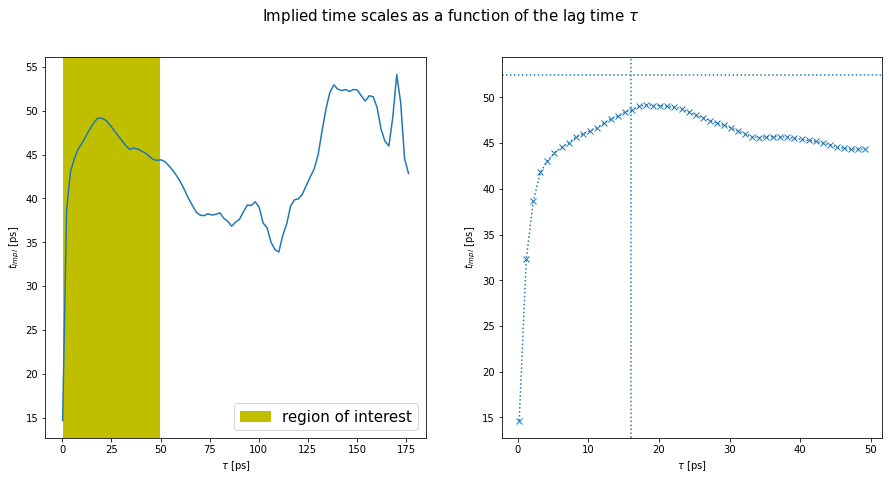

In [15]:
tau_range_1 = np.arange(1, 250, 5)
tau_range_2 = np.arange(1, 890, 10)
ef.plot_timp(tau_range_1, tau_range_2, s_1, axh_y=52.5, axv_x=16, figsize=(15,7))

##### TODO: adapt to data set, which is going to be used at last
The implied time scale first rises sharply and then reaches a plateau at a lag time range of roughly $[13 \text{ps} - 27 \text{ps}]$. After that, the implied time scale rises again and later drops a lot. For even larger lag times (not displayed here), the implied time scale fluctuates heavily. The further focus is therefore brought to lag times up to $50 \text{ps}$.
At small lag times, the sharp rise is due to the fact, that too many structural changes are wrongly mistaken for state transitions. 

Considering the implied time scales, calculated from the above state definition, a minimum lag time of about $\tau = 16 \text{ps}$ is suggested. From that time on $t_{impl}(\tau)$ shows the smallest slope.

# Geometrical cores

Even if a good lag time is chosen, there might be still "wrongly" counted state transitions. Especially at the borders between state regions it is not clear, which state the system should be assigned to. Here, conformational fluctuations lead to fluctuations on the $\Phi/\Psi$-plane and subsequently to false state transitions.  
This problem can be solved by introducing core regions. A core is defined as some area around the center of a state, i.e. the point of highest occupation probability. Within this core the system is said to be in that state. To get into another state the system needs to "move" into the core of another state. If the system is between two cores it is still assigned to the previously visited core (and hence its state). This way fluctuations are not mistaken for state transitions.  
  
In the above presented state definition, there was initially no area between state regions. Every side of a rectangle was directly next to the side of another rectangle. In the following, the rectangles are made smaller, so that there is a gap between each of the state regions. 

With the function `change_core` from *state_dicts.py* the set of rectangles can be modified, so that there is a gap between neighbouring state regions. It takes as an input the previously defined state dictionary **rect_dict_1** and a parameter **ds**, which defines the width of the gap (in radians) between the rectangles. It returns a dictionary with indices, specifying the new rectangles. 
Two more state dictionaries **rect_dict_2** and **rect_dict_3** are defined below and are visualized.

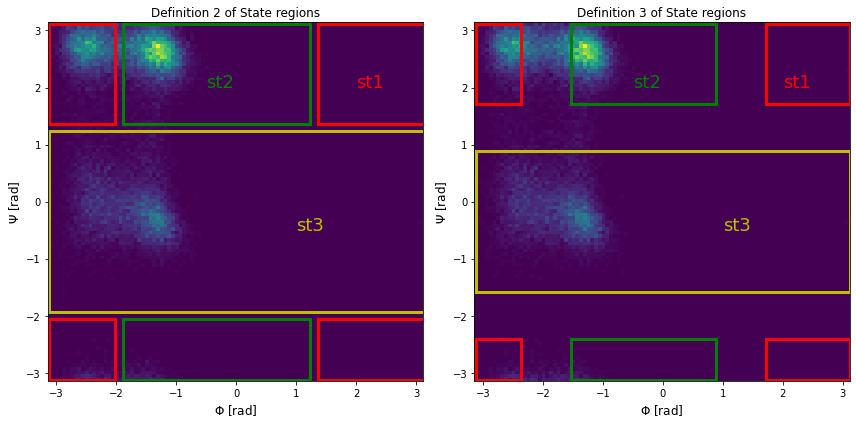

In [16]:
# call change_core to shrink the rectangles
ds_2 = 5/360*2*np.pi  # 5degrees = pi/36
rect_dict_2_core = state_dicts.change_core(rect_dict_1, ds=ds_2)

# call change_core to shrink the rectangles
ds_3 = 45/360*2*np.pi  # 45degrees = pi/4
rect_dict_3_core = state_dicts.change_core(rect_dict_1, ds=ds_3)

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12,6))

ef.visualize_states(rect_dict_2_core, phi, psi,ax=ax1, color_list=['r', 'g', 'y'])
ax1.set_title('Definition 2 of State regions')
ef.visualize_states(rect_dict_3_core, phi, psi, ax=ax2, color_list=['r', 'g', 'y'])
ax2.set_title('Definition 3 of State regions')

plt.tight_layout()
plt.show()

Two more state definitions where made. In the first one the gap between rectangles is set to $\frac{\pi}{36}$ and in the second it is $\frac{\pi}{4}$. The plot above shows the effect of coring on the state regions in the $\Phi/\Psi$-plane.

In the following, the new state trajectories,$s_2$ and $s_3$, for the state definitions 2 and 3 are defined, using the function `make_state_traj` as above. The parameters **core_def** is set to True, so the trajectory is checked for entries without state assignment. Here the previously visited state is inserted. 

In [17]:
s_2 = ef.make_state_traj(phi, psi, rect_dict_2_core, core_def=True)
s_3 = ef.make_state_traj(phi, psi, rect_dict_3_core, core_def=True)

##### Below, the effect of geometrical coring on the implicit time scales is shown. 

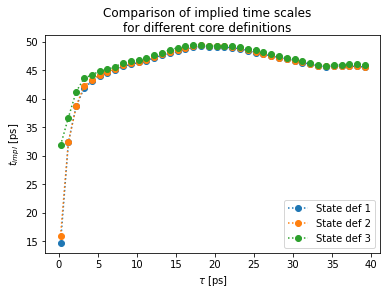

In [18]:
tau_range = np.arange(1, 200, 5)
ef.compare_timp(tau_range, [s_1, s_2, s_3], ls=':', marker='o')

It can be seen, that the small gap of $ds_2 = \frac{pi}{36}$ did not have a serious effect on the implied time scales. The state definition with a gap of $ds_3 = \frac{\pi}{4}$ however caused a smaller slope at lag times between $10 \text{ps}$ and $20 \text{ps}$. Also at lower lag times the curve is allready more "converged" to a constant behaviour.   
As a result, the suggested lag times for the different state definitions are as follows:
* State def 1 : $\tau = 16\text{ps}$
* State def 2 : $\tau = 15\text{ps}$
* State def 3 : $\tau = 10\text{ps}$

# Validation of Markov State Model

As mentioned in the introdcution, a markovian process exhibits no sign of a "memory". What this means is that if a system is described by the probability vector $p(t_0)$ at some reference time $t_0$, the probablity vector $p(t)=p(t_0+\Delta t)$ at the time $t$ is only dependent on the probablity distribution $p(t_0)$ and the time difference $\Delta t$. It is not dependent on the states the system might visit during the timespan $\Delta t$.  
In the markov model, the propagation of $p$ is done in time increments of $\tau$ by multiplying with $T(\tau)$. This means that one can either reach $t$ with one large time step, corresponding to a transition matrix $T(\Delta t=m\cdot \tau)$ or with multiple shorter time steps, which would correspond to $T^m(\tau)$.   
If the system exhibits no memory and is therefore markovian, these two propagations would be equivalent and the model would fulfill the so called *Chapman-Kolmogorov-equation*:

\begin{equation}\label{eq:CKE}
    T(m\cdot \tau) = T^m(\tau)
\end{equation}
  
To test this, a *Chapman-Kolmogorov-test* is conducted. For a given lag time $\tau = n_{\tau}\cdot dt$, the probability $P(0,i;t,i)$ to be in state $i$ at the time $t=n_t\cdot dt = m\cdot n_{\tau}\cdot dt$ when initialised in state $i$ is calculated by evaluating $T(n_t) = T(m\cdot n_{\tau})$ and also by evaluating $T^m(n_{\tau})$. According to equation \ref{eq:CKE} these should be the same. This procedure is done for all three states and for all of the three state definitions. The resulting curves are plotted for three different lag times.

##### Calculation of validation data
The function `calc_MSM_validation_data` takes as an input a list, `n_tau_list`, with lag times, represented as integer multiples of the time step $dt$ between trajectory frames. It also takes in a state trajectory, `s`. The time column of `s` is converted, so that the time is also represented in integer multiples of $dt$. For every lag "time" $n{\tau}$ in `n_tau_list`, a list with all multiples, $m$, of $n{\tau}$ is determined, so that for $m\cdot n{\tau}$ there is also an entry in `s`.  
For all of these multiples, the transition matrix $T^m(n{\tau})$ is calculated and stored in an numpy array. These arrays (one for every $n{\tau}$) are stored in a dictionary, `tau_data`. This dictionary also contains a list of $m\cdot n{\tau}$, so that the transition matrices can be assigned to a point in time.  
  
The collection of multiples $m(n{\tau}$ gives a subset of the time points in `s`. The reference data is calculated for every time point $n_t$ for which at least one transition matrix $T^m(n{\tau})$ was calculated, with $m\cdot n{\tau} = n_t$. This list of $n_t$ together with the calculated transition matrices $T(n_t)$ is stored in another list called `ref_data`. The function returns `ref_data` and `tau_data`.  
  
   
This data set is calculated for all there state definitions. The function `plot_MSM_val` takes a list with three data sets (one for each state definitions) and plots them on a (3x3) grid. For each state definition the three diagonal elements of the transition matrices are compared. (!!! describe above why diagonal elements and what probability those are.)

In [ ]:
# create a list of lag times for the calculation of the MSM validation data
tau_list = [3, 8, 16] # in ps 
dt = 0.2 # ps 
n_tau_list = [int(tau/dt) for tau in tau_list]

# calculate the data sets for all three state definitions
data_1 = ef.calc_MSM_validation_data(n_tau_list, s_1, 3)

data_2 = ef.calc_MSM_validation_data(n_tau_list, s_2, 3)

data_3 = ef.calc_MSM_validation_data(n_tau_list, s_3, 3)

data_matrix = np.array([data_1, data_2, data_3])


In [ ]:
subplot_kw = {'xlim': (3, 600), 
              'xscale': ('log')}
ef.plot_MSM_val(data_matrix,to_state=(1,2), params = subplot_kw, add_MSM_kw={'ref_points':50}, figsize=(12,16))

##### TODO: 
Description of plot. 


### Relationship between Chapman-Kolmogorov-equation an implied time scales

Equation \ref{eq:CKE} should be valid, no matter in which basis the linear transformation is represented. Using the matrix $D_T(\tau)$ as defined in section **3.2** it could also be written as 
\begin{align}
    D_T(m\cdot \tau) = 
    \left( 
        \begin{array}{ccc}
               \lambda_1(m\cdot \tau) & 0 & 0 \\
               0 & \lambda_2(m\cdot \tau) & 0 \\
               0 & 0 & \lambda_3(m\cdot \tau) \\
        \end{array}
    \right) =
    \left( 
        \begin{array}{ccc}
               \lambda_1(\tau)^m & 0 & 0 \\
               0 & \lambda_2(\tau)^m & 0 \\
               0 & 0 & \lambda_3(\tau)^m \\
        \end{array}  
    \right)
\end{align}

For $\lambda_1 = 1$, this is clearly fulfilled. For $\lambda_2$ this equation leads to the condition that the implied time scales should be constant because:


\begin{align}
    t_{impl}(m\cdot \tau) &
    = -\frac{m\cdot \tau}{ln(\lambda_2(m\cdot \tau))} &
    = -\frac{m\cdot \tau}{ln(\lambda_2(\tau)^m)} &
    = -\frac{m\cdot \tau}{m\cdot ln(\lambda_2(\tau))} &
    = t_{impl}(\tau)
\end{align}


# Summary 

In this project, the construction of a Markov State Model, based on MD simulation data of alanine dipeptide (AD) was shown. From the simulation data, the backbone dihedral angle pair $\Phi/\Psi$ of AD was calculated. In the Ramachandran plot three metastable energy minimas were found. The $\Phi/\Psi$-plane was partitioned into rectangles to create state regions. Every rectangle was assigned to on of the three states. Using cores, three different state definitions were made, which differed by the gap size, $ds$, between the chosen rectangles. 
* State def 1 : $ds = 0$ 
* State def 2 : $ds = \frac{\pi}{36}$
* State def 3 : $ds = \frac{\pi}{4}$  
Based on these state definitions, three state trajectories were generated and used to calculate transition matrices.  

The effect of coring was then evaluated by performing a validation of the markovinity of each state definition. 
By comparing the implied time scales the following values for the lag times $\tau$ of the model were found to be a good choice. 
* State def 1 : $\tau = 16\text{ps}$
* State def 2 : $\tau = 15\text{ps}$
* State def 3 : $\tau = 10\text{ps}$  
Increasing the gap size causes the implied time scales to becom constant at lower $\tau$ values. This can be explained by the fact that fluctuation around the borders of state regions (e.g. the rectangles), lead to falsely counted state transitions. Coring eliminates this effect.  
The effect of coring was futher validated by performing a Chapman-Kolmogorov-Test for three different lag times $\{\tau_1=?, \tau_2=?, \tau_3=?\}$
